In [1]:
!date

Wed Feb 12 03:25:53 JST 2020


In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [5]:
stansimsdir="stan-sims-NEJMChina"
dirs = !ls -d {stansimsdir}/*
dirs

['stan-sims-NEJMChina/gamma-no_truncation',
 'stan-sims-NEJMChina/lognormal-no_truncation',
 'stan-sims-NEJMChina/weibull-no_truncation']

In [6]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [7]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation'], dtype='<U13')

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,6.112,0.966,4.228,8.045,0.004,0.003,71328.0,64844.0,78774.0,58521.0,1.0
sd_SI,2.399,1.012,1.060,4.341,0.004,0.004,53077.0,41644.0,85020.0,54642.0,1.0
param1,1.720,0.173,1.365,2.039,0.001,0.000,78364.0,78364.0,90391.0,62638.0,1.0
param2,0.374,0.122,0.183,0.622,0.000,0.000,73986.0,62540.0,92518.0,67064.0,1.0


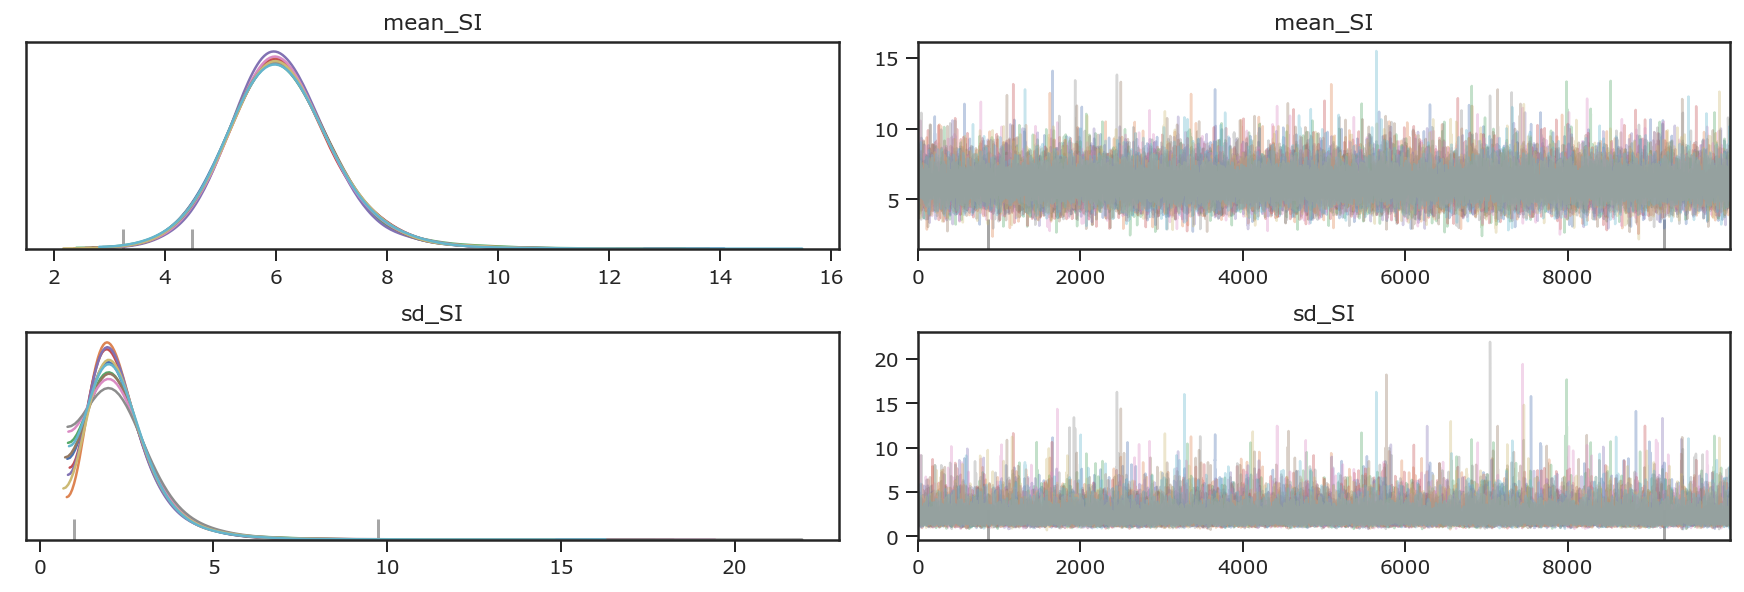

In [11]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,6.823,1.370,4.411,9.517,0.006,0.004,56349.0,47940.0,75276.0,49007.0,1.0
sd_SI,2.953,1.515,1.109,5.739,0.007,0.005,46892.0,41772.0,76721.0,49708.0,1.0
param1,7.691,5.153,0.613,17.776,0.016,0.011,105114.0,104347.0,85929.0,66710.0,1.0
param2,1.178,0.824,0.064,2.793,0.003,0.002,103239.0,103239.0,78492.0,57048.0,1.0


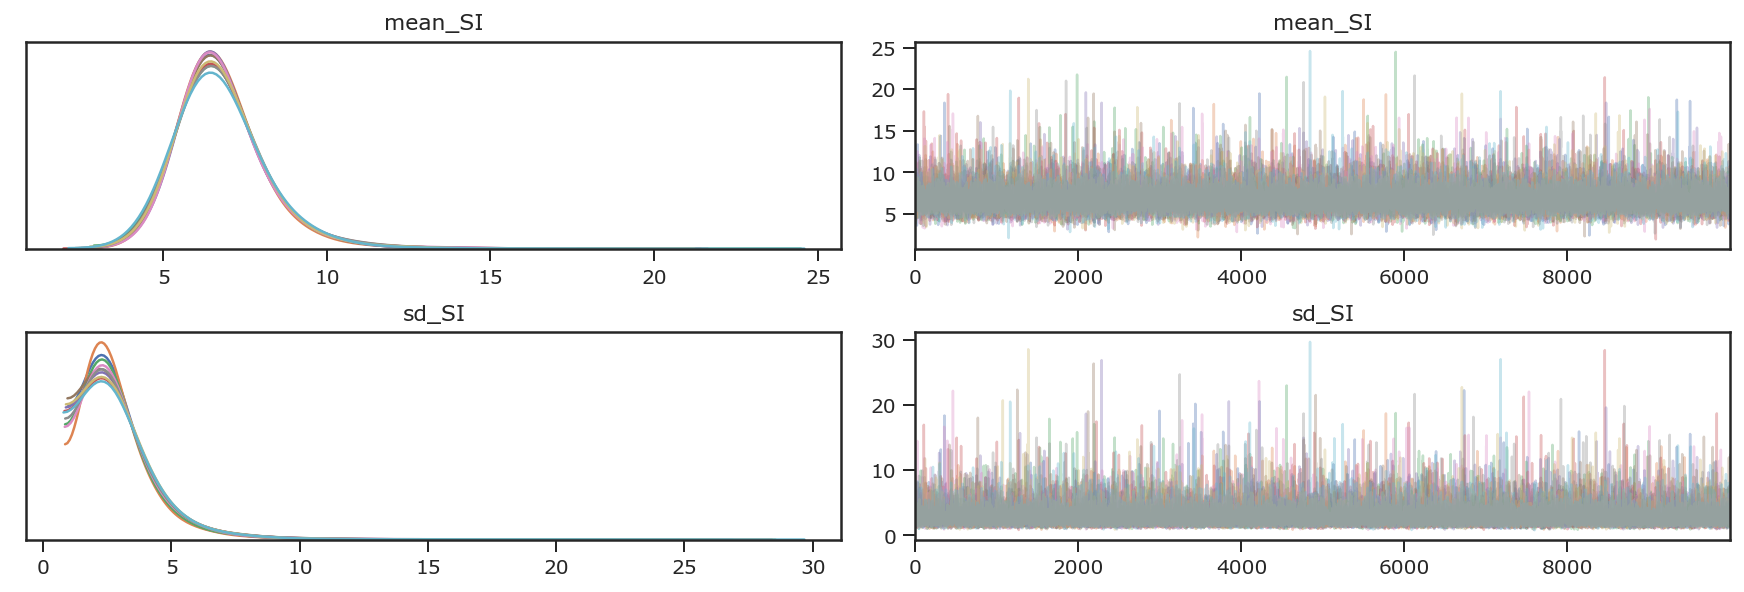

In [9]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,6.636,0.965,4.877,8.421,0.005,0.004,39053.0,26784.0,69810.0,45604.0,1.0
sd_SI,2.015,1.007,0.882,3.532,0.006,0.004,27551.0,27551.0,64321.0,43312.0,1.0
param1,4.179,1.511,1.494,7.191,0.005,0.004,77426.0,77426.0,68436.0,53083.0,1.0
param2,7.304,1.039,5.400,9.293,0.005,0.004,41365.0,30162.0,69538.0,44510.0,1.0


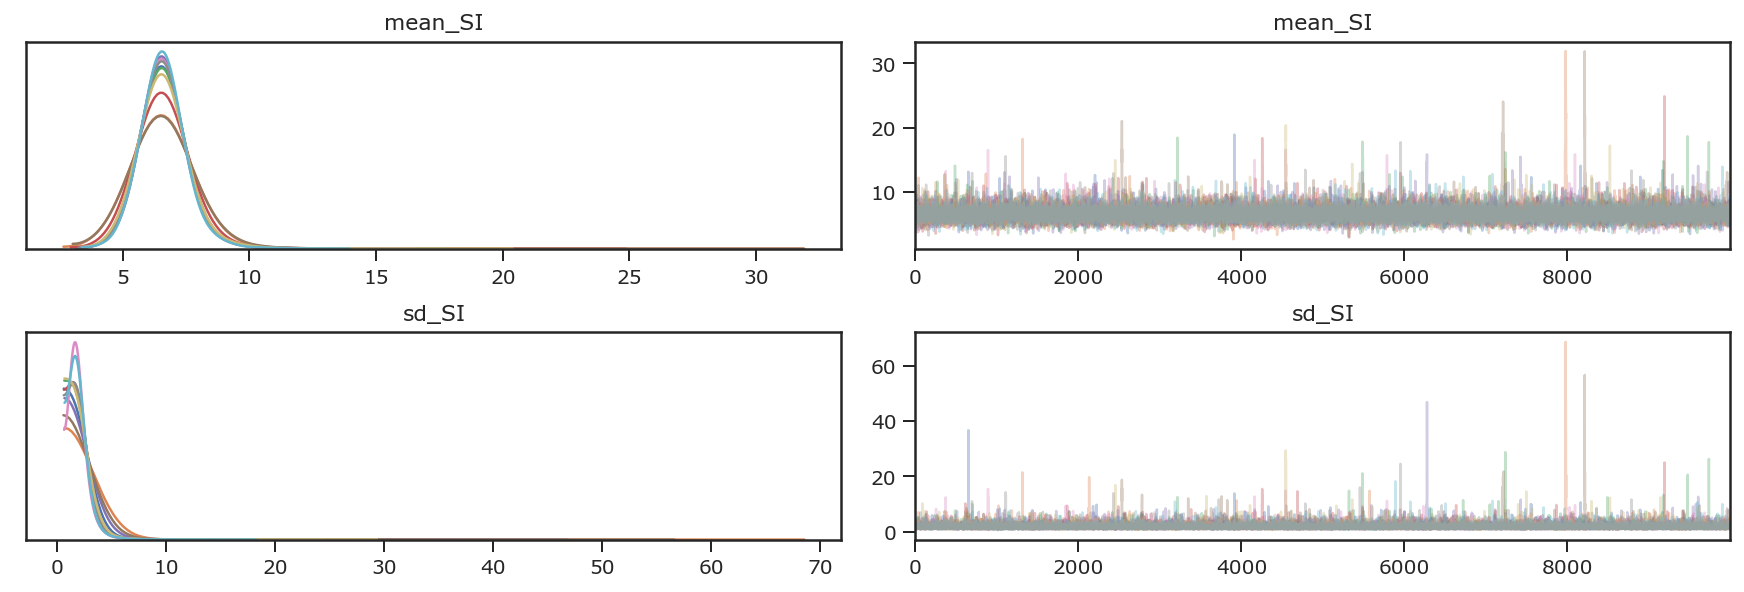

In [10]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls {stansimsdir}/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

## Comparing different models

gamma-no_truncation
['gamma', 'no_truncation', '6.8 (4.8, 10.1)', '2.9 (1.4, 6.8)', '3.0 (0.7, 4.7)', '6.3 (4.2, 8.9)', '11.3 (8.1, 22.3)', '14.0 (9.5, 31.3)']
lognormal-no_truncation
['lognormal', 'no_truncation', '6.1 (4.4, 8.2)', '2.4 (1.2, 5.0)', '3.2 (1.3, 4.6)', '5.7 (3.8, 7.5)', '10.0 (7.5, 16.6)', '12.7 (9.0, 25.1)']
weibull-no_truncation
['weibull', 'no_truncation', '6.6 (5.0, 8.7)', '2.0 (1.1, 4.2)', '3.5 (1.3, 5.2)', '6.6 (4.9, 8.4)', '9.4 (7.8, 15.3)', '10.5 (8.4, 19.2)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,28.7,0.00,0.454,no_truncation,"6.6 (5.0, 8.7)","2.0 (1.1, 4.2)","3.5 (1.3, 5.2)","6.6 (4.9, 8.4)","9.4 (7.8, 15.3)","10.5 (8.4, 19.2)"
1,gamma,29.4,0.74,0.299,no_truncation,"6.8 (4.8, 10.1)","2.9 (1.4, 6.8)","3.0 (0.7, 4.7)","6.3 (4.2, 8.9)","11.3 (8.1, 22.3)","14.0 (9.5, 31.3)"
2,lognormal,29.9,1.24,0.246,no_truncation,"6.1 (4.4, 8.2)","2.4 (1.2, 5.0)","3.2 (1.3, 4.6)","5.7 (3.8, 7.5)","10.0 (7.5, 16.6)","12.7 (9.0, 25.1)"


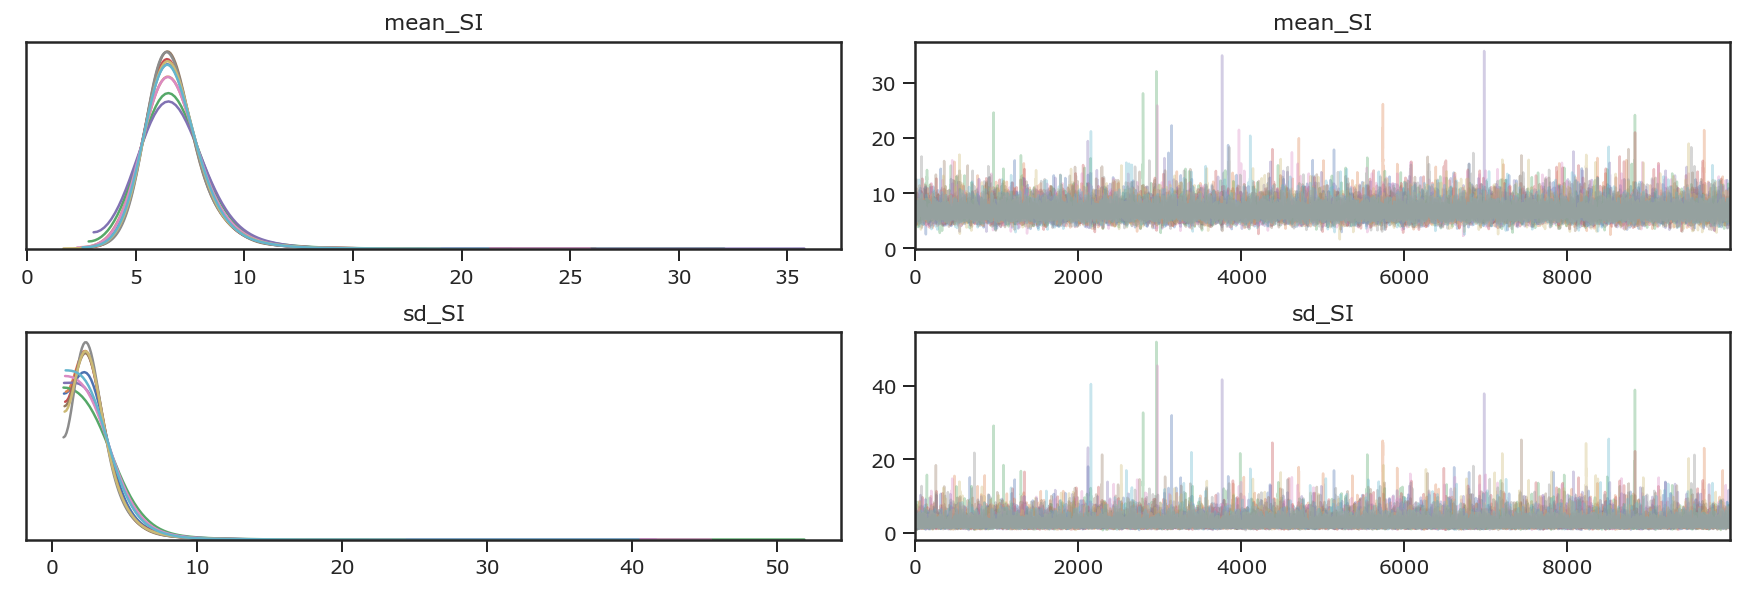

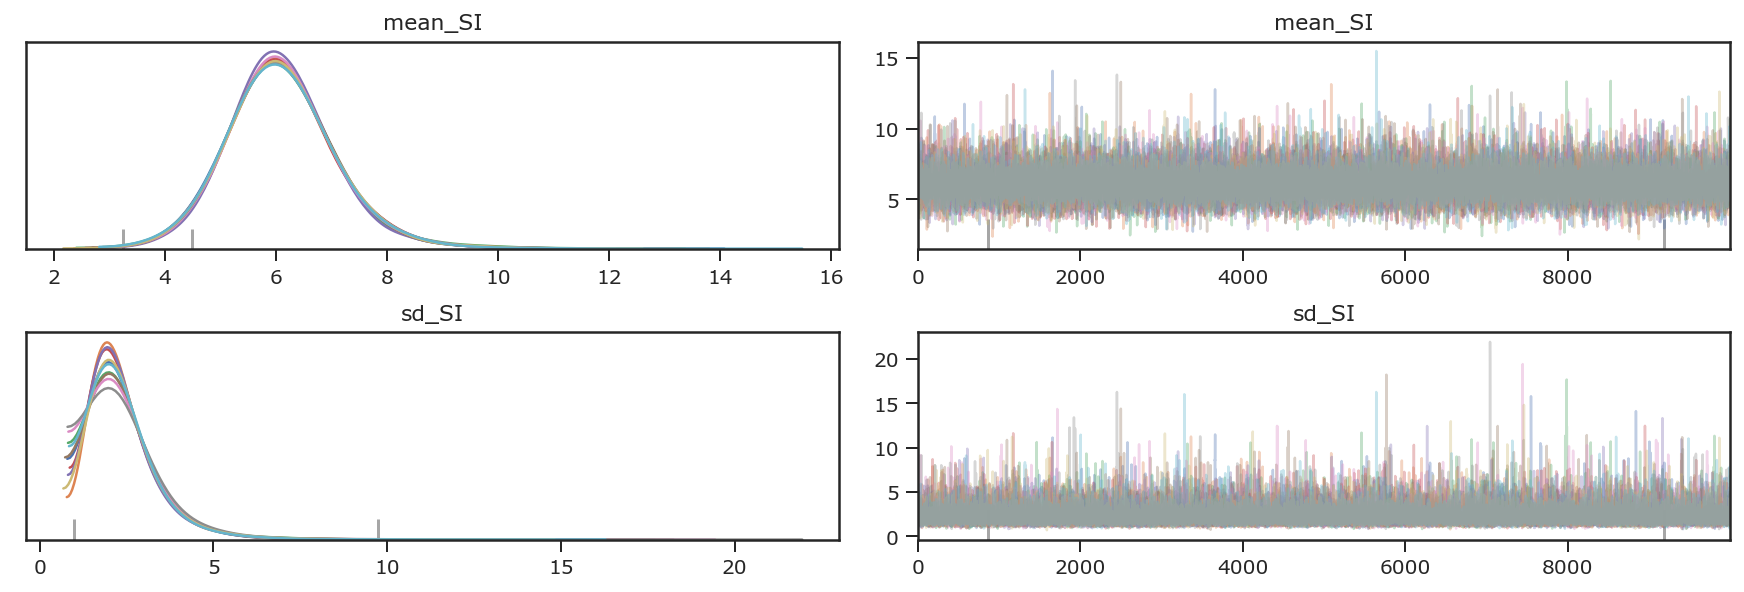

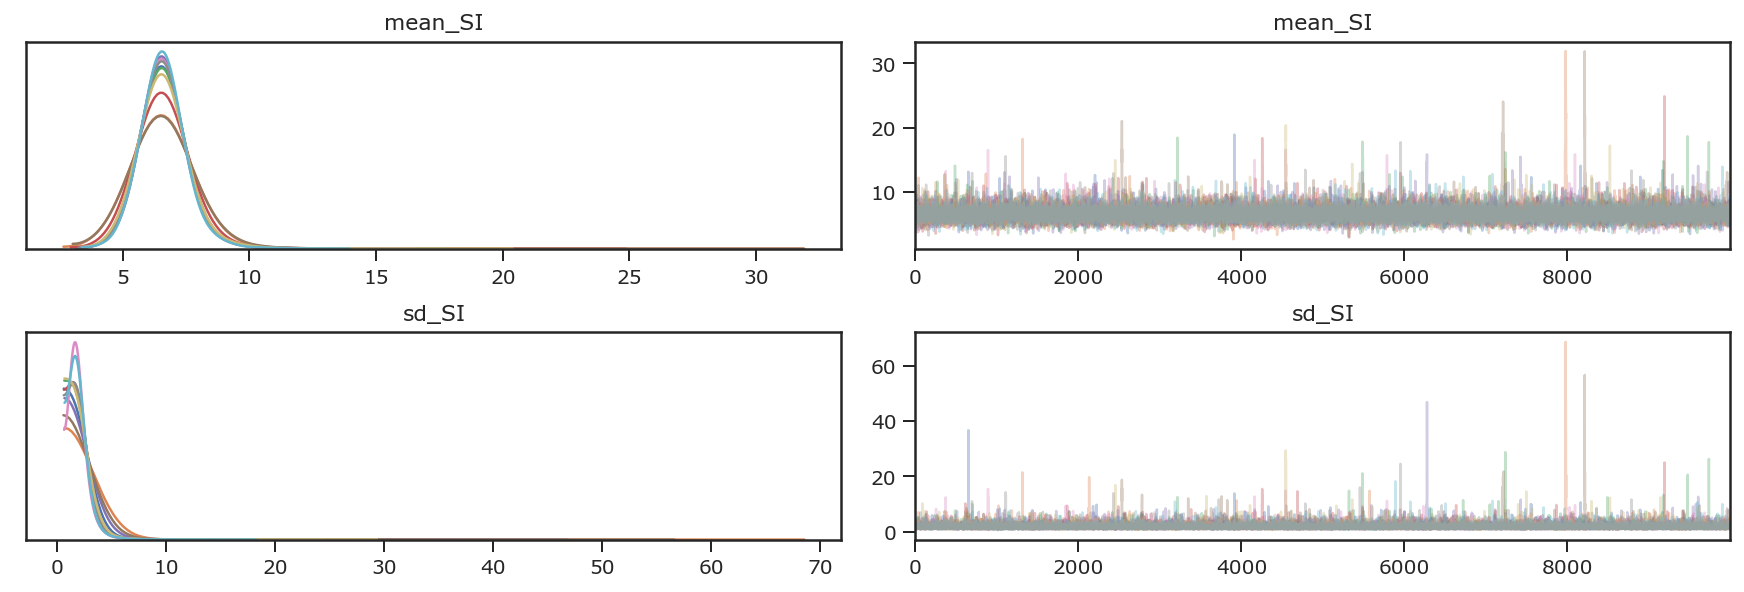

In [12]:
!mkdir -p ../../results/Andrei/Stan-sims-NEJMChina/traceplots
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))

        posterior_glob = !ls {stansimsdir}/{folder}/trace-*

        cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        cmdstan_stats = get_stats(cmdstan_data)  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

        az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
        plt.savefig("../../results/Andrei/Stan-sims-NEJMChina/traceplots/trace-"+folder+".pdf", format='pdf')

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models)

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims-NEJMChina/summary-'+truncation_type+'.xlsx')